# Đánh Giá và Trực Quan Hóa Mô Hình PM2.5

Notebook này thực hiện đánh giá và so sánh hai mô hình:
1. **LSTM**: Mô hình LSTM cho chuỗi thời gian
2. **XGBoost**: Mô hình machine learning gradient boosting

## Mục tiêu:
- Tải các mô hình đã được huấn luyện
- Thực hiện dự đoán trên tập test
- Tính toán các chỉ số đánh giá: R², RMSE, MSE, MAE
- Trực quan hóa kết quả với các biểu đồ:
  - Biến động PM2.5 theo thời gian (Actual vs Predicted)
  - Scatter plot Actual vs Predicted
  - Phân phối lỗi
  - So sánh chỉ số theo trạm

In [1]:
# Import required libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
import warnings
from pathlib import Path

# Suppress warnings
warnings.filterwarnings('ignore')

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import ( Dense )

# Machine Learning libraries
import xgboost as xgb
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, 
    mean_absolute_percentage_error, r2_score
)

# Visualization settings
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print(f"[OK] Libraries imported successfully!")
print(f"[INFO] TensorFlow version: {tf.__version__}")
print(f"[INFO] XGBoost version: {xgb.__version__}")
print(f"[INFO] Using GPU: {len(tf.config.list_physical_devices('GPU')) > 0}")

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

2025-12-04 16:55:06.981454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764867307.220227      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764867307.299909      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

[OK] Libraries imported successfully!
[INFO] TensorFlow version: 2.18.0
[INFO] XGBoost version: 2.0.3
[INFO] Using GPU: False


2025-12-04 16:55:24.612360: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## 1. Tải Dữ Liệu Test

Tải dữ liệu test đã được xử lý từ định dạng parquet

In [2]:
# Detect environment and setup paths
IN_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ
IN_COLAB = 'google.colab' in sys.modules

if IN_KAGGLE:
    # Kaggle paths - separate input datasets for each model
    data_dir = Path("/kaggle/input/preprocessed-hong-kong-pollutant-dataset/processed")
    lstm_models_dir = Path("/kaggle/input/lstm-pm2-5")
    xgb_models_dir = Path("/kaggle/input/xgboost-pm2-5")
    results_dir = Path("/kaggle/working")
    print(f"[KAGGLE] Running in Kaggle environment")
elif IN_COLAB:
    # Google Colab paths
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = Path("/content/drive/MyDrive/pm25-data/processed")
    lstm_models_dir = Path("/content/drive/MyDrive/pm25-models/lstm")
    xgb_models_dir = Path("/content/drive/MyDrive/pm25-models/xgboost")
    results_dir = Path("/content/drive/MyDrive/pm25-results")
    print(f"[COLAB] Running in Google Colab")
else:
    # Local development
    data_dir = Path("../data/processed")
    lstm_models_dir = Path("../models/lstm")
    xgb_models_dir = Path("../models/xgboost")
    results_dir = Path("../results")
    print(f"[LOCAL] Running locally")

# Create directories if they don't exist (for local/colab)
if not IN_KAGGLE:
    for dir_path in [lstm_models_dir, xgb_models_dir, results_dir]:
        dir_path.mkdir(parents=True, exist_ok=True)

print(f"[SETUP] Directory structure:")
print(f"   Data: {data_dir}")
print(f"   LSTM Models: {lstm_models_dir}")
print(f"   XGBoost Models: {xgb_models_dir}")
print(f"   Results: {results_dir}")

# Check if data exists
if not data_dir.exists():
    print(f"[ERROR] Data directory not found: {data_dir}")
    print(f"[INFO] Please run 01_data_preprocessing.ipynb first")
    sys.exit(1)

print(f"[SUCCESS] Data directory found: {data_dir}")

# Load test data for each model type
try:
    lstm_test_data = pd.read_parquet(data_dir / 'lstm_sequences' / 'test')
    xgb_test_data = pd.read_parquet(data_dir / 'xgboost' / 'test')
    
    # Use LSTM data as the main reference
    test_data = lstm_test_data
    
    print(f"[SUCCESS] Test data loaded successfully!")
    print(f"   LSTM Shape: {lstm_test_data.shape}")
    print(f"   XGBoost Shape: {xgb_test_data.shape}")
    print(f"   Date range: {test_data['datetime'].min()} to {test_data['datetime'].max()}")
    print(f"   Locations: {test_data['location_id'].nunique()} unique locations")
except FileNotFoundError:
    print(f"[ERROR] Test data not found. Please run preprocessing first.")
    sys.exit(1)

# Load metadata
try:
    with open(data_dir / 'feature_metadata.json', 'r') as f:
        feature_metadata = json.load(f)
    
    with open(data_dir / 'scaler_params.json', 'r') as f:
        scaler_params = json.load(f)
    
    print(f"[SUCCESS] Metadata loaded successfully!")
    print(f"   Features: {len(feature_metadata['deep_learning_features'])}")
    print(f"   Target: {feature_metadata['target']}")
    
except FileNotFoundError:
    print(f"[ERROR] Metadata files not found")
    sys.exit(1)

[KAGGLE] Running in Kaggle environment
[SETUP] Directory structure:
   Data: /kaggle/input/preprocessed-hong-kong-pollutant-dataset/processed
   LSTM Models: /kaggle/input/lstm-pm2-5
   XGBoost Models: /kaggle/input/xgboost-pm2-5
   Results: /kaggle/working
[SUCCESS] Data directory found: /kaggle/input/preprocessed-hong-kong-pollutant-dataset/processed
[SUCCESS] Test data loaded successfully!
   LSTM Shape: (42934, 21)
   XGBoost Shape: (43270, 74)
   Date range: 2022-11-28 13:00:00 to 2025-09-30 16:00:00
   Locations: 14 unique locations
[SUCCESS] Metadata loaded successfully!
   Features: 18
   Target: PM2_5_log_scaled


In [3]:
# Prepare test data for different models
sequence_cols = [col for col in lstm_test_data.columns if col.endswith('_sequence')]
print(f"[DATA PREP] Found {len(sequence_cols)} sequence features")

# First, synchronize datasets by location_id and datetime
print(f"\n[SYNC] Synchronizing datasets by location_id and datetime:")
print(f"   LSTM data shape: {lstm_test_data.shape}")
print(f"   XGBoost data shape: {xgb_test_data.shape}")

# Create merge keys
lstm_test_data['merge_key'] = lstm_test_data['location_id'].astype(str) + '_' + lstm_test_data['datetime'].astype(str)
xgb_test_data['merge_key'] = xgb_test_data['location_id'].astype(str) + '_' + xgb_test_data['datetime'].astype(str)

# Find common samples
common_keys = set(lstm_test_data['merge_key']).intersection(set(xgb_test_data['merge_key']))
print(f"   Common samples found: {len(common_keys)}")
print(f"   LSTM-only samples: {len(lstm_test_data) - len(common_keys)}")
print(f"   XGB-only samples: {len(xgb_test_data) - len(common_keys)}")

# Filter both datasets to common samples
lstm_synced = lstm_test_data[lstm_test_data['merge_key'].isin(common_keys)].copy()
xgb_synced = xgb_test_data[xgb_test_data['merge_key'].isin(common_keys)].copy()

# Sort both by merge_key to ensure same order
lstm_synced = lstm_synced.sort_values('merge_key').reset_index(drop=True)
xgb_synced = xgb_synced.sort_values('merge_key').reset_index(drop=True)

# Verify synchronization
print(f"   Synchronized LSTM data shape: {lstm_synced.shape}")
print(f"   Synchronized XGB data shape: {xgb_synced.shape}")

# Verify keys match
keys_match = (lstm_synced['merge_key'] == xgb_synced['merge_key']).all()
print(f"   Keys match verification: {keys_match}")

if not keys_match:
    print("[ERROR] Failed to synchronize datasets!")
    raise ValueError("Dataset synchronization failed")

def prepare_sequence_data(df, sequence_cols, target_col='target_value'):
    """Convert pandas DataFrame with sequence columns to numpy arrays"""
    print(f"   Converting {len(df)} samples...")
    
    # Extract sequences
    X = np.array([
        np.stack([df[col].iloc[i] for col in sequence_cols], axis=0)
        for i in range(len(df))
    ])
    
    # Transpose to (samples, timesteps, features)
    X = X.transpose(0, 2, 1)
    
    # Extract target values
    y = df[target_col].values
    
    print(f"   X shape: {X.shape} (samples, timesteps, features)")
    print(f"   y shape: {y.shape}")
    
    return X, y

def prepare_xgboost_data(df, target_col='PM2_5_log_scaled'):
    """Prepare tabular data for XGBoost (same as training)"""
    # Check target column names
    possible_targets = ['PM2_5_log_scaled', 'target_value', 'PM2_5']
    actual_target = None
    for target in possible_targets:
        if target in df.columns:
            actual_target = target
            break
    
    if actual_target is None:
        print(f"[ERROR] No target column found. Available columns: {list(df.columns)}")
        return None, None
    
    print(f"   Using target column: {actual_target}")
    
    # Extract target
    y = df[actual_target].values.astype(np.float32)
    
    # Extract features (exclude non-feature columns)
    exclude_cols = [actual_target, 'location_id', 'datetime', 'merge_key']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    print(f"   Number of features: {len(feature_cols)}")
    print(f"   Target column: {actual_target}")
    
    # Extract features
    X = df[feature_cols].values.astype(np.float32)
    
    return X, y

# Prepare synchronized data for LSTM model
print("\n[LSTM] Preparing synchronized sequence data:")
X_test_dl, y_test = prepare_sequence_data(lstm_synced, sequence_cols)

# Prepare synchronized data for XGBoost
print("\n[XGBOOST] Preparing synchronized tabular data:")
X_test_xgb, y_test_xgb = prepare_xgboost_data(xgb_synced)

if X_test_xgb is not None:
    print(f"   XGBoost input shape: {X_test_xgb.shape} (tabular features)")
    print(f"   XGBoost target shape: {y_test_xgb.shape}")
else:
    print(f"   [ERROR] Failed to prepare XGBoost data")

# Extract additional information from synchronized data
test_dates = lstm_synced['datetime'].values
test_locations = lstm_synced['location_id'].values
unique_locations = lstm_synced['location_id'].unique()

# Verify target consistency
if y_test_xgb is not None and len(y_test_xgb) == len(y_test):
    target_diff = np.abs(y_test - y_test_xgb).max()
    print(f"\n[TARGET VERIFICATION] Max target difference: {target_diff:.6f}")
    if target_diff < 1e-6:
        print("[SUCCESS] Targets are identical across datasets")
    else:
        print("[WARNING] Targets differ between datasets")
else:
    print(f"\n[ERROR] Target size mismatch after sync")

print(f"\n[SYNCHRONIZED TEST SET INFO]")
print(f"   Samples: {len(X_test_dl):,}")
print(f"   LSTM - Sequence length: {X_test_dl.shape[1]} timesteps")
print(f"   LSTM - Features per timestep: {X_test_dl.shape[2]}")
print(f"   XGBoost - Tabular features: {X_test_xgb.shape[1]}")
print(f"   Unique locations: {len(unique_locations)}")
print(f"   Date range: {test_dates.min()} to {test_dates.max()}")
print(f"   Target range: [{y_test.min():.4f}, {y_test.max():.4f}]")

# Use the main reference dataset for consistency
test_data = lstm_synced

[DATA PREP] Found 18 sequence features

[SYNC] Synchronizing datasets by location_id and datetime:
   LSTM data shape: (42934, 21)
   XGBoost data shape: (43270, 74)
   Common samples found: 42934
   LSTM-only samples: 0
   XGB-only samples: 336
   Synchronized LSTM data shape: (42934, 22)
   Synchronized XGB data shape: (42934, 75)
   Keys match verification: True

[LSTM] Preparing synchronized sequence data:
   Converting 42934 samples...
   X shape: (42934, 24, 18) (samples, timesteps, features)
   y shape: (42934,)

[XGBOOST] Preparing synchronized tabular data:
   Using target column: PM2_5_log_scaled
   Number of features: 71
   Target column: PM2_5_log_scaled
   XGBoost input shape: (42934, 71) (tabular features)
   XGBoost target shape: (42934,)

[TARGET VERIFICATION] Max target difference: 0.000000
[SUCCESS] Targets are identical across datasets

[SYNCHRONIZED TEST SET INFO]
   Samples: 42,934
   LSTM - Sequence length: 24 timesteps
   LSTM - Features per timestep: 18
   XGBoo

## 2. Utility Functions

Định nghĩa các hàm tiện ích cho tính toán chỉ số đánh giá và denormalization

In [4]:
def calculate_metrics(y_true, y_pred, model_name="Model"):
    """Calculate and display regression metrics"""
    
    # Basic metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Safe MAPE calculation
    non_zero_mask = np.abs(y_true) > 1e-6
    if np.sum(non_zero_mask) > 10:
        try:
            mape = mean_absolute_percentage_error(y_true[non_zero_mask], y_pred[non_zero_mask]) * 100
            mape = min(mape, 500.0)  # Cap at 500%
        except:
            mape = None
    else:
        mape = None
    
    # Print results
    print(f"\n[METRICS] {model_name} Performance:")
    print("-" * 60)
    print(f"   R²:   {r2:.6f}   (Coefficient of Determination)")
    print(f"   RMSE: {rmse:.6f}   (Root Mean Square Error)")
    print(f"   MSE:  {mse:.6f}   (Mean Squared Error)")
    print(f"   MAE:  {mae:.6f}   (Mean Absolute Error)")
    
    if mape is not None:
        print(f"   MAPE: {mape:.4f}%   (Mean Absolute Percentage Error)")
    else:
        print(f"   MAPE: N/A        (Cannot calculate - too many zero values)")
    
    print("-" * 60)
    
    return {
        'r2': r2,
        'rmse': rmse,
        'mse': mse,
        'mae': mae,
        'mape': mape
    }

def denormalize_pm25(normalized_values, scaler_params):
    """Denormalize PM2.5 values to original scale"""
    
    # Auto-detect if log transformation was applied
    if 'PM2_5_log' in scaler_params:
        pm25_params = scaler_params['PM2_5_log']
        min_val = pm25_params['min']
        max_val = pm25_params['max']
        
        # Denormalize to log scale
        log_values = normalized_values * (max_val - min_val) + min_val
        
        # Inverse log transform: exp(x) - 1
        original_values = np.expm1(log_values)
        
        print(f"[DENORM] Applied inverse log transform")
        
    elif 'PM2_5' in scaler_params:
        pm25_params = scaler_params['PM2_5']
        min_val = pm25_params['min']
        max_val = pm25_params['max']
        
        # Standard denormalization
        original_values = normalized_values * (max_val - min_val) + min_val
        
        print(f"[DENORM] Standard denormalization")
    else:
        raise KeyError(f"PM2.5 scaling parameters not found. Available: {list(scaler_params.keys())}")
    
    return original_values

def create_model_comparison_table(results_dict):
    """Create a comparison table of model results"""
    
    print("\n" + "="*90)
    print("MODEL COMPARISON TABLE")
    print("="*90)
    
    # Header
    print(f"{'Model':<25} {'R²':<8} {'RMSE':<10} {'MSE':<10} {'MAE':<10} {'MAPE (%)':<10}")
    print("-" * 90)
    
    # Results for each model
    for model_name, metrics in results_dict.items():
        mape_str = f"{metrics['mape']:.2f}" if metrics['mape'] is not None else "N/A"
        print(f"{model_name:<25} {metrics['r2']:<8.4f} {metrics['rmse']:<10.2f} "
              f"{metrics['mse']:<10.2f} {metrics['mae']:<10.2f} {mape_str:<10}")
    
    print("-" * 90)
    
    # Find best model for each metric
    best_r2_model = max(results_dict.keys(), key=lambda k: results_dict[k]['r2'])
    best_rmse_model = min(results_dict.keys(), key=lambda k: results_dict[k]['rmse'])
    best_mae_model = min(results_dict.keys(), key=lambda k: results_dict[k]['mae'])
    
    print(f"\n[BEST MODELS]")
    print(f"   Highest R²: {best_r2_model} ({results_dict[best_r2_model]['r2']:.4f})")
    print(f"   Lowest RMSE: {best_rmse_model} ({results_dict[best_rmse_model]['rmse']:.2f})")
    print(f"   Lowest MAE: {best_mae_model} ({results_dict[best_mae_model]['mae']:.2f})")

print("[FUNCTIONS] Utility functions defined successfully!")

[FUNCTIONS] Utility functions defined successfully!


## 3. Tải và Đánh Giá Các Mô Hình

Tải hai mô hình đã được huấn luyện và thực hiện dự đoán trên tập test

In [5]:
# Dictionary to store all model predictions and results
model_results = {}
model_predictions = {}

print("[MODELS] Loading and evaluating trained models...")
print("="*80)

# ==========================================
# 1. LSTM Model
# ==========================================
print("\n[1] LSTM Model")
print("-" * 40)

try:
    # Load LSTM model from its specific directory
    lstm_model_path = lstm_models_dir / "lstm_pm25.keras"
    
    lstm_model = None
    if os.path.exists(lstm_model_path):
        try:
            lstm_model = load_model(lstm_model_path)
            print(f"[SUCCESS] LSTM model loaded from: {lstm_model_path}")
        except Exception as e:
            print(f"[FAILED] Could not load from {lstm_model_path}: {e}")
    else:
        print("[WARNING] LSTM model not found.")

    # Make predictions
    if lstm_model is not None:
        print("[PREDICT] Making predictions...")
        y_pred_lstm = lstm_model.predict(X_test_dl, batch_size=256, verbose=0)
        y_pred_lstm = y_pred_lstm.flatten()
    
        # Calculate metrics
        lstm_metrics = calculate_metrics(y_test, y_pred_lstm, "LSTM")
        model_results['LSTM'] = lstm_metrics
        model_predictions['LSTM'] = y_pred_lstm

except Exception as e:
    print(f"[ERROR] Failed to process LSTM model: {e}")

[MODELS] Loading and evaluating trained models...

[1] LSTM Model
----------------------------------------
[SUCCESS] LSTM model loaded from: /kaggle/input/lstm-pm2-5/lstm_pm25.keras
[PREDICT] Making predictions...

[METRICS] LSTM Performance:
------------------------------------------------------------
   R²:   0.878233   (Coefficient of Determination)
   RMSE: 0.049281   (Root Mean Square Error)
   MSE:  0.002429   (Mean Squared Error)
   MAE:  0.033369   (Mean Absolute Error)
   MAPE: 9.7350%   (Mean Absolute Percentage Error)
------------------------------------------------------------


In [6]:
# ==========================================
# 2. XGBoost Model
# ==========================================
print("\n[2] XGBoost Model")
print("-" * 40)

try:
    # Load XGBoost model from its specific directory
    xgb_model_path = xgb_models_dir / "xgboost_pm25.json"
    
    if os.path.exists(xgb_model_path):
        xgb_model = XGBRegressor()
        xgb_model.load_model(xgb_model_path)
        print(f"[SUCCESS] XGBoost model loaded from: {xgb_model_path}")
        
        # Check feature compatibility
        expected_features = getattr(xgb_model, 'n_features_in_', None)
        if expected_features:
            print(f"[INFO] Model expects {expected_features} features")
        print(f"[INFO] Data has {X_test_xgb.shape[1]} features")
        
        # Verify data is synchronized
        print(f"[INFO] LSTM samples: {len(y_test)}")
        print(f"[INFO] XGBoost samples: {X_test_xgb.shape[0]}")
        
        if len(y_test) == X_test_xgb.shape[0]:
            print(f"[SUCCESS] Datasets are properly synchronized!")
        else:
            print(f"[ERROR] Datasets are not synchronized despite sync process")
            raise ValueError("Dataset synchronization verification failed")
        
    else:
        print("[WARNING] XGBoost model not found.")
        xgb_model = None
    
    # Make predictions on synchronized data
    if xgb_model is not None:
        print("[PREDICT] Making predictions on synchronized data...")
        y_pred_xgb = xgb_model.predict(X_test_xgb)
        
        # Calculate metrics using synchronized target
        xgb_metrics = calculate_metrics(y_test, y_pred_xgb, "XGBoost")
        model_results['XGBoost'] = xgb_metrics
        model_predictions['XGBoost'] = y_pred_xgb
        
        print(f"[SUCCESS] XGBoost evaluation completed with {len(y_pred_xgb)} synchronized samples")
        
except Exception as e:
    print(f"[ERROR] Failed to process XGBoost model: {e}")
    
print("\n[COMPLETE] All models evaluated successfully!")
print(f"   Models processed: {len(model_results)}")
print(f"   Available predictions: {list(model_predictions.keys())}")


[2] XGBoost Model
----------------------------------------
[SUCCESS] XGBoost model loaded from: /kaggle/input/xgboost-pm2-5/xgboost_pm25.json
[INFO] Model expects 71 features
[INFO] Data has 71 features
[INFO] LSTM samples: 42934
[INFO] XGBoost samples: 42934
[SUCCESS] Datasets are properly synchronized!
[PREDICT] Making predictions on synchronized data...

[METRICS] XGBoost Performance:
------------------------------------------------------------
   R²:   0.955995   (Coefficient of Determination)
   RMSE: 0.029625   (Root Mean Square Error)
   MSE:  0.000878   (Mean Squared Error)
   MAE:  0.018602   (Mean Absolute Error)
   MAPE: 5.5740%   (Mean Absolute Percentage Error)
------------------------------------------------------------
[SUCCESS] XGBoost evaluation completed with 42934 synchronized samples

[COMPLETE] All models evaluated successfully!
   Models processed: 2
   Available predictions: ['LSTM', 'XGBoost']


In [7]:
# Create model comparison table
create_model_comparison_table(model_results)

# Denormalize all predictions to original scale
print(f"\n[DENORMALIZATION] Converting predictions to original PM2.5 scale...")

# Denormalize actual values
y_test_original = denormalize_pm25(y_test, scaler_params)
print(f"   Actual PM2.5 range: [{y_test_original.min():.2f}, {y_test_original.max():.2f}] μg/m³")

# Denormalize all model predictions
model_predictions_original = {}
original_metrics = {}

for model_name, predictions in model_predictions.items():
    # Verify prediction length
    if len(predictions) != len(y_test):
        print(f"[WARNING] {model_name} prediction length mismatch: {len(predictions)} vs {len(y_test)}")
        
    # Denormalize predictions
    pred_original = denormalize_pm25(predictions, scaler_params)
    model_predictions_original[model_name] = pred_original
    
    # Calculate metrics on original scale
    original_metrics[model_name] = calculate_metrics(
        y_test_original, pred_original, f"{model_name} (Original Scale μg/m³)"
    )
    
    print(f"   {model_name} PM2.5 range: [{pred_original.min():.2f}, {pred_original.max():.2f}] μg/m³ ({len(pred_original)} samples)")

print(f"\n[SUCCESS] All models denormalized to original scale with synchronized data!")


MODEL COMPARISON TABLE
Model                     R²       RMSE       MSE        MAE        MAPE (%)  
------------------------------------------------------------------------------------------
LSTM                      0.8782   0.05       0.00       0.03       9.74      
XGBoost                   0.9560   0.03       0.00       0.02       5.57      
------------------------------------------------------------------------------------------

[BEST MODELS]
   Highest R²: XGBoost (0.9560)
   Lowest RMSE: XGBoost (0.03)
   Lowest MAE: XGBoost (0.02)

[DENORMALIZATION] Converting predictions to original PM2.5 scale...
[DENORM] Applied inverse log transform
   Actual PM2.5 range: [0.00, 182.50] μg/m³
[DENORM] Applied inverse log transform

[METRICS] LSTM (Original Scale μg/m³) Performance:
------------------------------------------------------------
   R²:   0.894732   (Coefficient of Determination)
   RMSE: 4.213648   (Root Mean Square Error)
   MSE:  17.754829   (Mean Squared Error)
   MAE:

## 4. Trực Quan Hóa Kết Quả

Tạo các biểu đồ để so sánh hiệu suất của các mô hình

[VIZ] Creating Actual vs Predicted scatter plots...


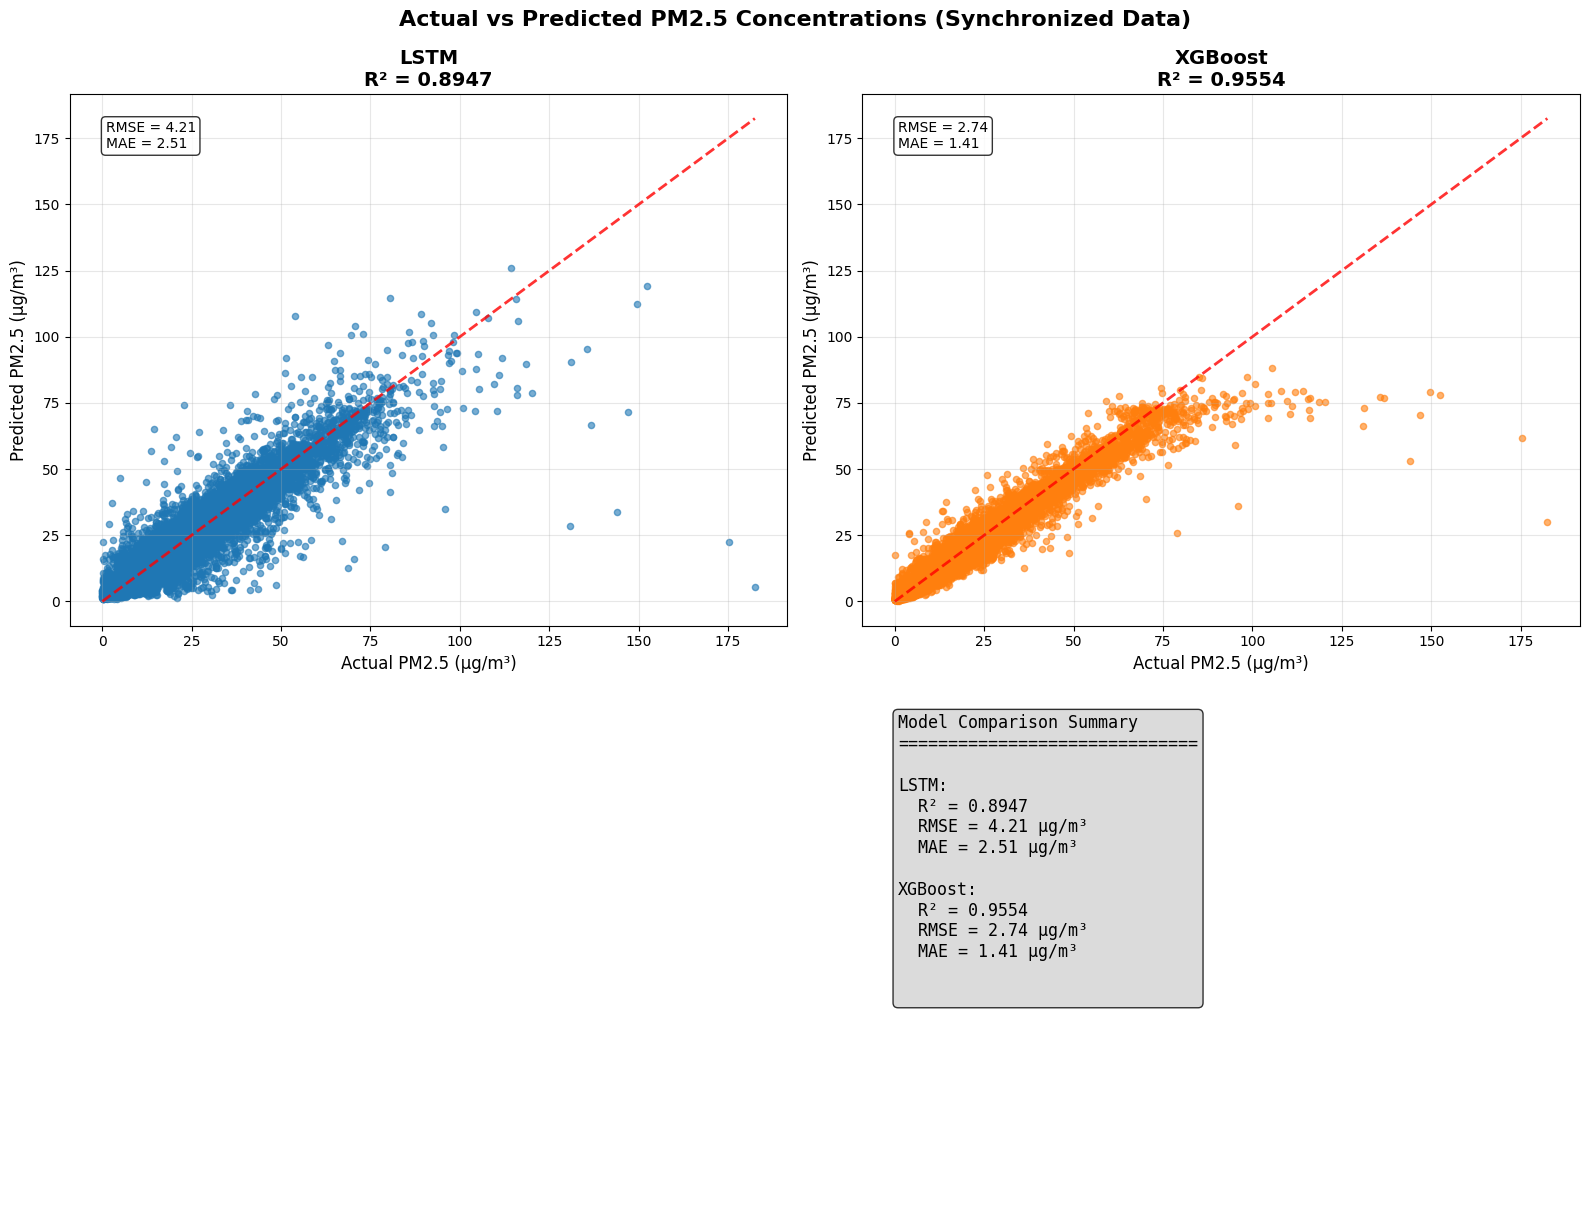

In [8]:
# Set up visualization style
plt.style.use('default')
sns.set_palette("Set2")
colors = ['#1f77b4', '#ff7f0e']  # Blue, Orange

# 1. Biểu đồ Actual vs Predicted (Scatter Plot)
print("[VIZ] Creating Actual vs Predicted scatter plots...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot for each model
for i, (model_name, predictions) in enumerate(model_predictions_original.items()):
    if i < 2:  # Only plot first 2 models
        row = i // 2
        col = i % 2
        
        # All data should be valid now due to synchronization
        axes[row, col].scatter(y_test_original, predictions, alpha=0.6, s=20, color=colors[i])
        
        # Perfect prediction line
        min_val = min(y_test_original.min(), predictions.min())
        max_val = max(y_test_original.max(), predictions.max())
        axes[row, col].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, alpha=0.8)
        
        axes[row, col].set_xlabel('Actual PM2.5 (μg/m³)', fontsize=12)
        axes[row, col].set_ylabel('Predicted PM2.5 (μg/m³)', fontsize=12)
        axes[row, col].set_title(f'{model_name}\nR² = {original_metrics[model_name]["r2"]:.4f}', fontsize=14, fontweight='bold')
        axes[row, col].grid(True, alpha=0.3)
        
        # Add correlation info
        axes[row, col].text(0.05, 0.95, 
                           f'RMSE = {original_metrics[model_name]["rmse"]:.2f}\nMAE = {original_metrics[model_name]["mae"]:.2f}',
                           transform=axes[row, col].transAxes,
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                           verticalalignment='top', fontsize=10)

# Model comparison metrics in the remaining subplots
axes[1, 0].axis('off')
axes[1, 1].axis('off')

comparison_text = "Model Comparison Summary\n" + "="*30 + "\n\n"

for model_name, metrics in original_metrics.items():
    comparison_text += f"{model_name}:\n"
    comparison_text += f"  R² = {metrics['r2']:.4f}\n"
    comparison_text += f"  RMSE = {metrics['rmse']:.2f} μg/m³\n"
    comparison_text += f"  MAE = {metrics['mae']:.2f} μg/m³\n\n"

axes[1, 1].text(0.05, 0.95, comparison_text, transform=axes[1, 1].transAxes,
                fontsize=12, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.suptitle('Actual vs Predicted PM2.5 Concentrations (Synchronized Data)', fontsize=16, fontweight='bold', y=1.02)
plt.show()

[VIZ] Creating time series comparison plots...


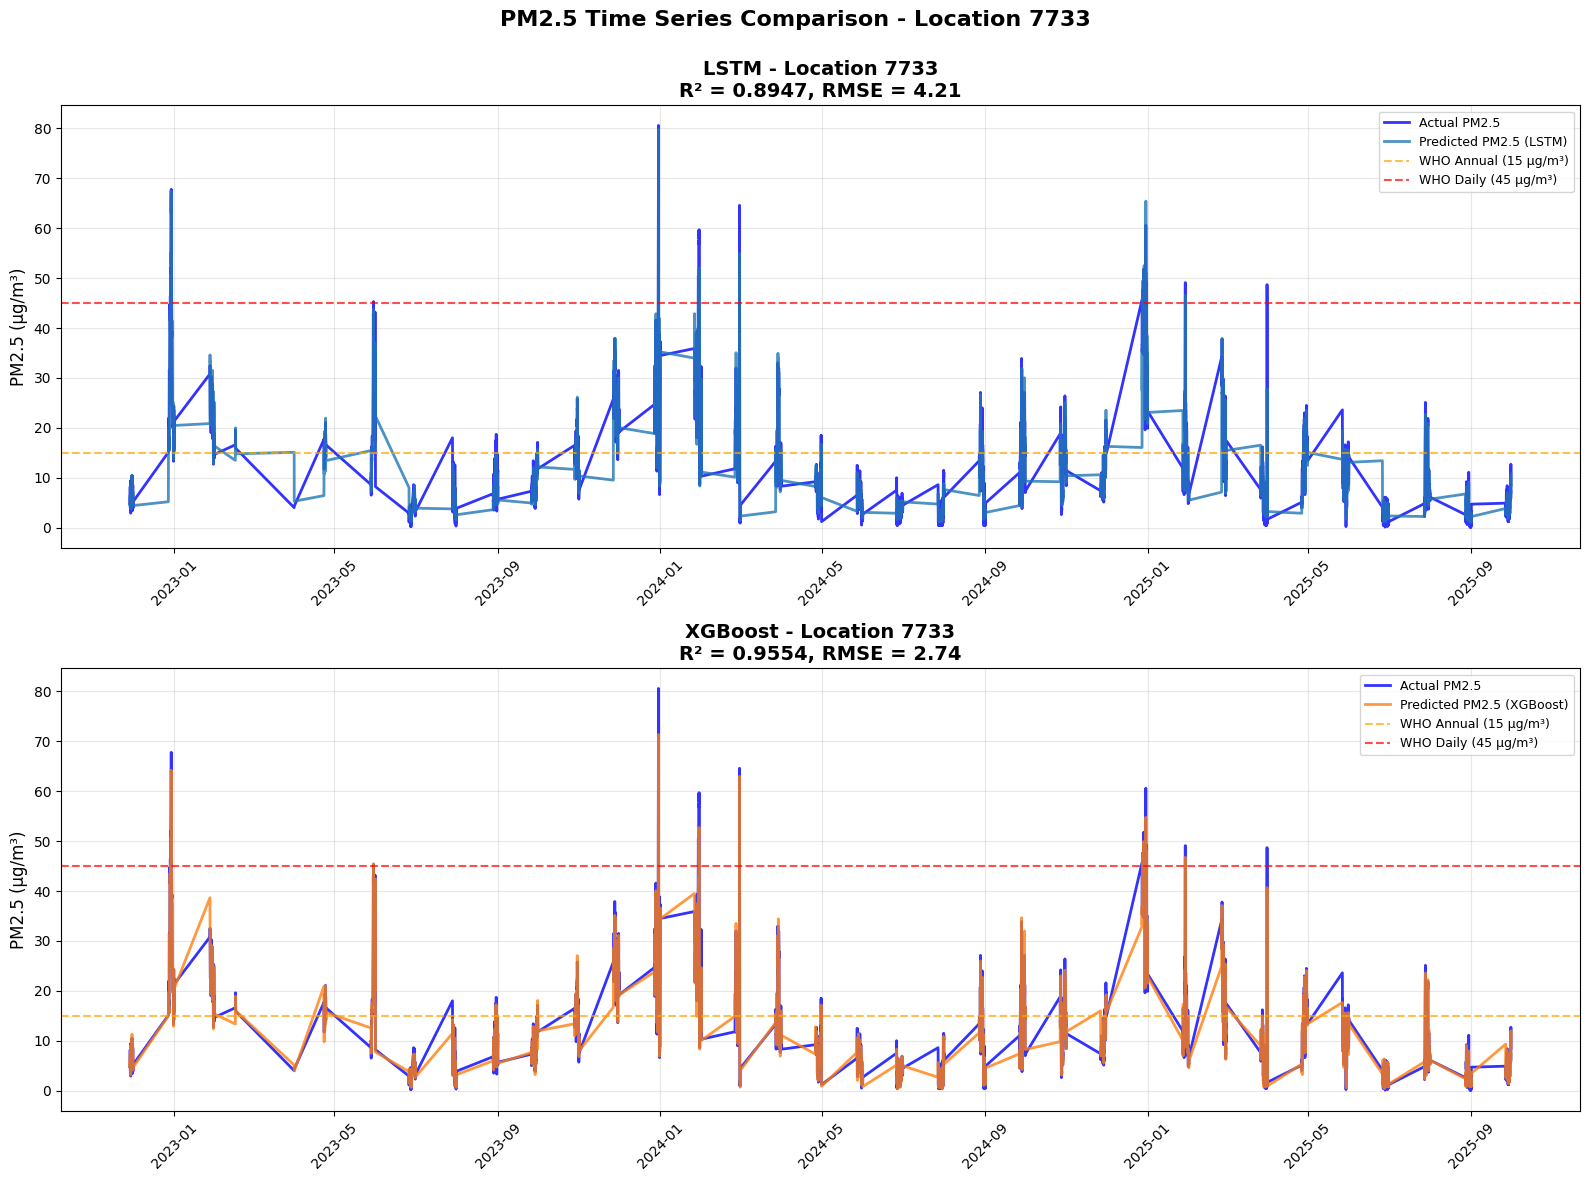

In [9]:
# 2. Biểu đồ biến động PM2.5 theo thời gian
print("[VIZ] Creating time series comparison plots...")

# Select a representative location for detailed analysis
sample_location = '7733'
location_mask = test_locations == sample_location
location_indices = np.where(location_mask)[0]

if len(location_indices) > 50:  # Ensure sufficient data points
    # Extract data for selected location
    location_dates = test_dates[location_mask]
    location_actual = y_test_original[location_indices]
    
    # Create time series plot
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    
    # Plot for each model
    for i, (model_name, predictions) in enumerate(model_predictions_original.items()):
        if i < 2:
            location_pred = predictions[location_indices]
            
            # Sort by date for proper line plotting
            sort_idx = np.argsort(location_dates)
            sorted_dates = location_dates[sort_idx]
            sorted_actual = location_actual[sort_idx]
            sorted_pred = location_pred[sort_idx]
            
            # Limit to last 200 points for clarity
            plot_dates = sorted_dates
            plot_actual = sorted_actual
            plot_pred = sorted_pred
            
            axes[i].plot(plot_dates, plot_actual, label='Actual PM2.5', linewidth=2, alpha=0.8, color='blue')
            axes[i].plot(plot_dates, plot_pred, label=f'Predicted PM2.5 ({model_name})', 
                        linewidth=2, alpha=0.8, color=colors[i])
            
            axes[i].set_ylabel('PM2.5 (μg/m³)', fontsize=12)
            axes[i].set_title(f'{model_name} - Location {sample_location}\nR² = {original_metrics[model_name]["r2"]:.4f}, RMSE = {original_metrics[model_name]["rmse"]:.2f}', 
                             fontsize=14, fontweight='bold')
            axes[i].legend(fontsize=11)
            axes[i].grid(True, alpha=0.3)
            
            # Add WHO guidelines
            axes[i].axhline(y=15, color='orange', linestyle='--', alpha=0.7, label='WHO Annual (15 μg/m³)')
            axes[i].axhline(y=45, color='red', linestyle='--', alpha=0.7, label='WHO Daily (45 μg/m³)')
            axes[i].legend(loc='upper right', fontsize=9)
            
            # Rotate x-axis labels
            axes[i].tick_params(axis='x', rotation=45)
    
    plt.suptitle(f'PM2.5 Time Series Comparison - Location {sample_location}', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()
    
else:
    print(f"[WARNING] Insufficient data for location {sample_location}. Skipping time series plot.")

[VIZ] Creating error distribution plots...


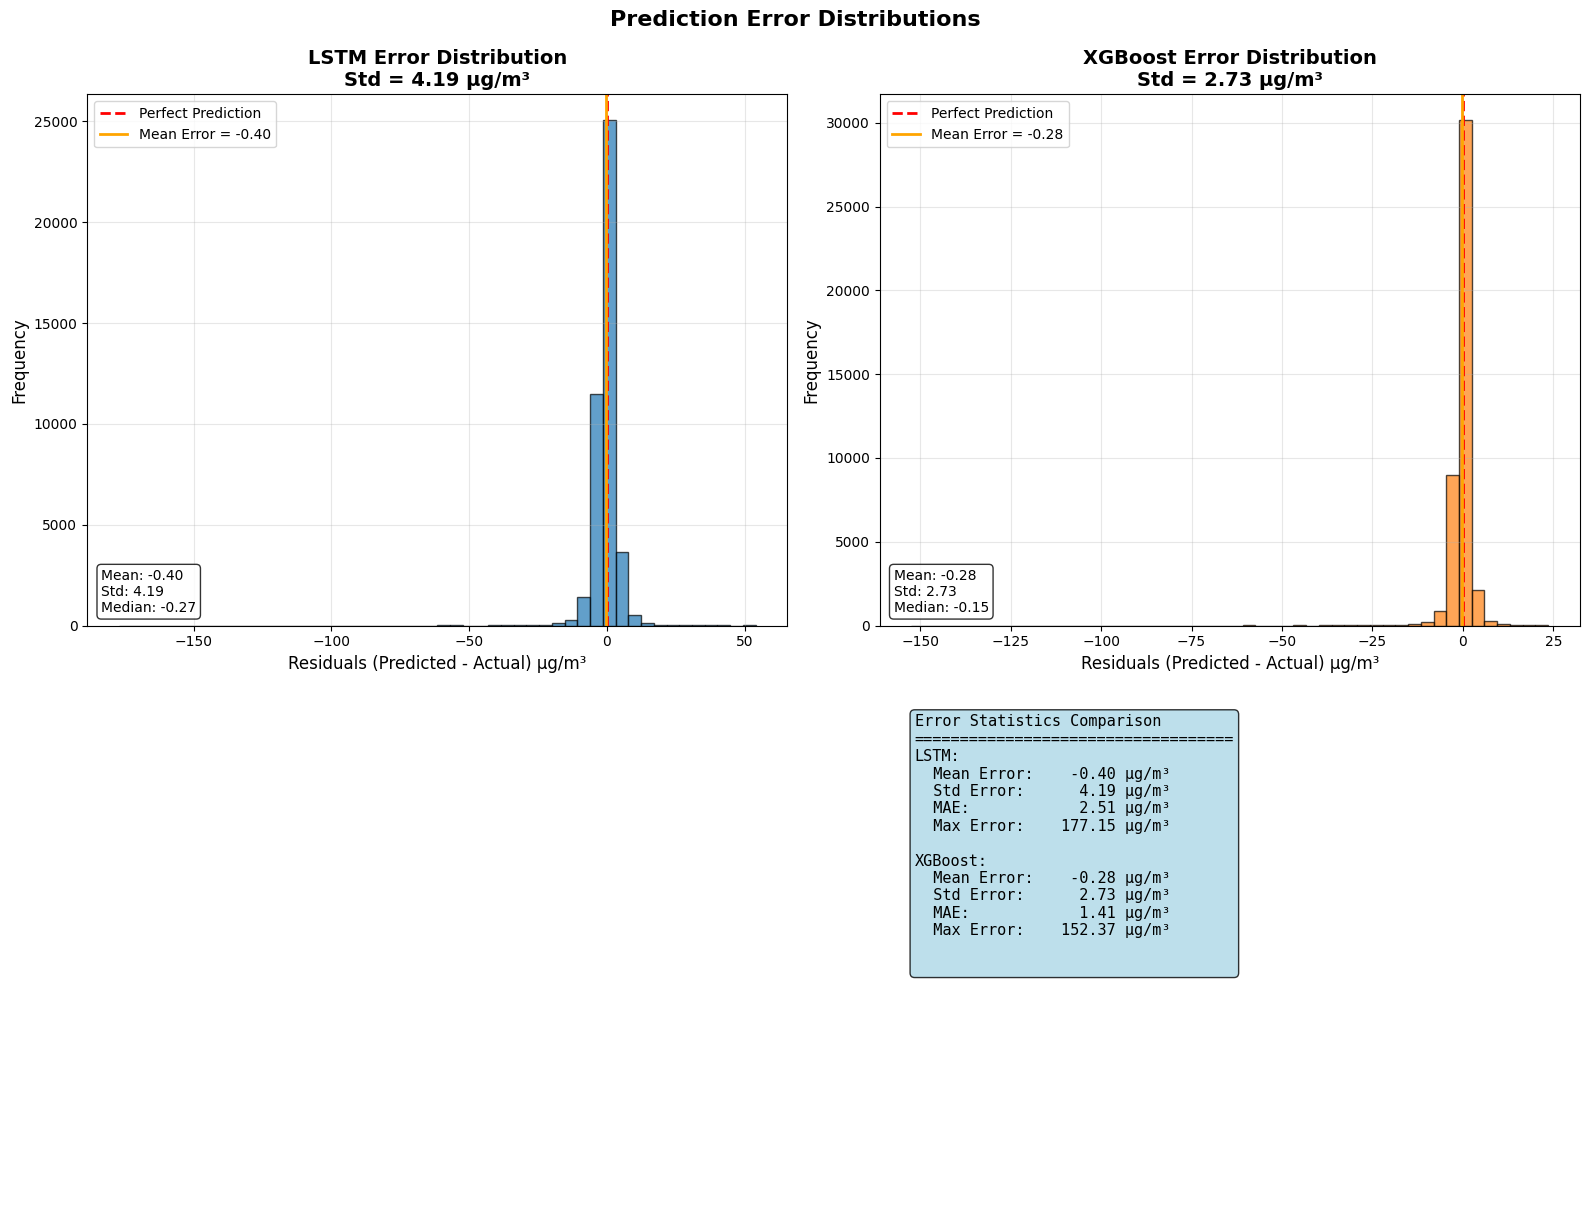

In [11]:
# 3. Phân phối lỗi (Error Distribution)
print("[VIZ] Creating error distribution plots...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, (model_name, predictions) in enumerate(model_predictions_original.items()):
    if i < 2:
        # Calculate residuals
        residuals = predictions - y_test_original
        
        # Plot position
        row = i // 2
        col = i % 2
        
        # Histogram of residuals
        axes[row, col].hist(residuals, bins=50, alpha=0.7, color=colors[i], edgecolor='black')
        axes[row, col].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
        axes[row, col].axvline(x=np.mean(residuals), color='orange', linestyle='-', linewidth=2, 
                              label=f'Mean Error = {np.mean(residuals):.2f}')
        
        axes[row, col].set_xlabel('Residuals (Predicted - Actual) μg/m³', fontsize=12)
        axes[row, col].set_ylabel('Frequency', fontsize=12)
        axes[row, col].set_title(f'{model_name} Error Distribution\nStd = {np.std(residuals):.2f} μg/m³', 
                                 fontsize=14, fontweight='bold')
        axes[row, col].legend(fontsize=10)
        axes[row, col].grid(True, alpha=0.3)
        
        # Add statistics
        stats_text = f'Mean: {np.mean(residuals):.2f}\nStd: {np.std(residuals):.2f}\nMedian: {np.median(residuals):.2f}'
        axes[row, col].text(0.02, 0.02, stats_text, transform=axes[row, col].transAxes,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                    verticalalignment='bottom', fontsize=10)

# Comparison of error statistics in the 4th subplot
axes[1, 1].axis('off')
error_text = "Error Statistics Comparison\n" + "="*35 + "\n"

for model_name, predictions in model_predictions_original.items():
    residuals = predictions - y_test_original
    error_text += f"{model_name}:\n"
    error_text += f"  Mean Error: {np.mean(residuals):>8.2f} μg/m³\n"
    error_text += f"  Std Error:  {np.std(residuals):>8.2f} μg/m³\n"
    error_text += f"  MAE:        {np.mean(np.abs(residuals)):>8.2f} μg/m³\n"
    error_text += f"  Max Error:  {np.max(np.abs(residuals)):>8.2f} μg/m³\n\n"

axes[1, 0].remove()
axes[1, 1].text(0.05, 0.95, error_text, transform=axes[1, 1].transAxes,
                fontsize=11, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.suptitle('Prediction Error Distributions', fontsize=16, fontweight='bold', y=1.02)
plt.show()

[VIZ] Creating station-wise performance comparison...


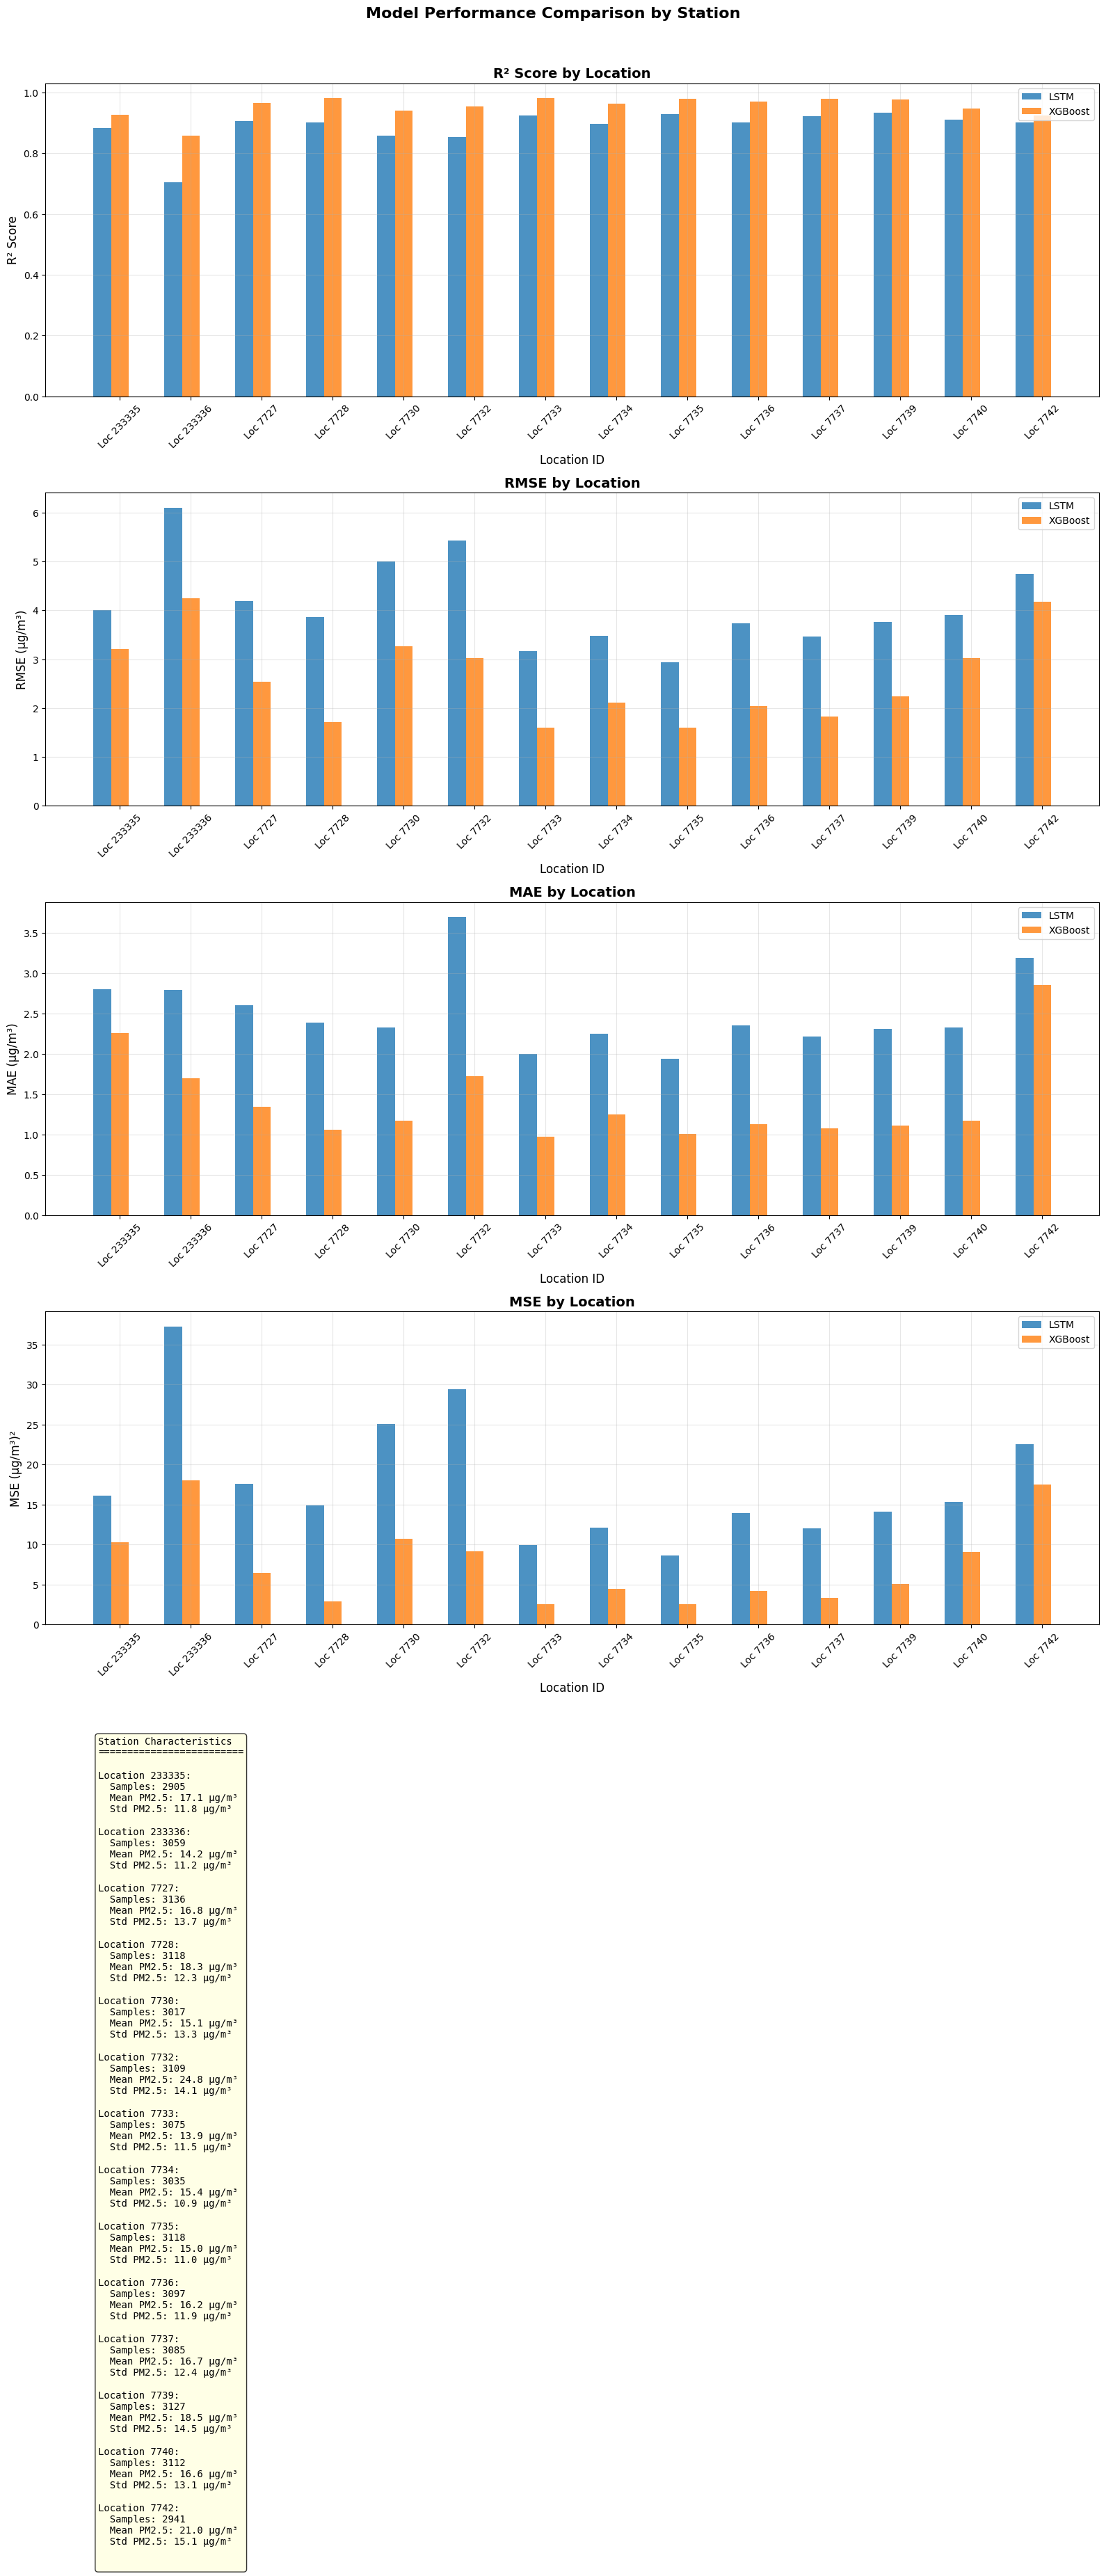


[STATION ANALYSIS] Detailed performance by station:
----------------------------------------------------------------------------------------------------
Location   Samples  Mean PM2.5   Best R² Model        Best RMSE Model     
----------------------------------------------------------------------------------------------------
233335     2905     17.1         XGBoost              XGBoost             
233336     3059     14.2         XGBoost              XGBoost             
7727       3136     16.8         XGBoost              XGBoost             
7728       3118     18.3         XGBoost              XGBoost             
7730       3017     15.1         XGBoost              XGBoost             
7732       3109     24.8         XGBoost              XGBoost             
7733       3075     13.9         XGBoost              XGBoost             
7734       3035     15.4         XGBoost              XGBoost             
7735       3118     15.0         XGBoost              XGBoost         

In [12]:
# 4. So sánh chỉ số theo trạm (Station Comparison)
print("[VIZ] Creating station-wise performance comparison...")

# Calculate performance for each location
location_performance = {}

for loc in unique_locations:  # Limit to first 8 locations for clarity
    loc_mask = test_locations == loc
    loc_indices = np.where(loc_mask)[0]
    
    if len(loc_indices) > 10:  # Minimum samples required
        loc_actual = y_test_original[loc_indices]
        
        location_performance[loc] = {
            'samples': len(loc_actual),
            'actual_mean': np.mean(loc_actual),
            'actual_std': np.std(loc_actual)
        }
        
        # Calculate metrics for each model at this location
        for model_name, predictions in model_predictions_original.items():
            loc_pred = predictions[loc_indices]
            
            loc_r2 = r2_score(loc_actual, loc_pred)
            loc_rmse = np.sqrt(mean_squared_error(loc_actual, loc_pred))
            loc_mae = mean_absolute_error(loc_actual, loc_pred)
            loc_mse = mean_squared_error(loc_actual, loc_pred)
            
            location_performance[loc][f'{model_name}_r2'] = loc_r2
            location_performance[loc][f'{model_name}_rmse'] = loc_rmse
            location_performance[loc][f'{model_name}_mae'] = loc_mae
            location_performance[loc][f'{model_name}_mse'] = loc_mse

# Create comparison plots
if location_performance:
    locations = list(location_performance.keys())
    n_locations = len(locations)
    
    fig, axes = plt.subplots(5, 1, figsize=(16, 36))
    
    # Prepare data for plotting
    model_names = list(model_predictions_original.keys())
    
    # R² comparison by station
    r2_data = {model: [location_performance[loc][f'{model}_r2'] for loc in locations] 
               for model in model_names}
    
    x_pos = np.arange(n_locations)
    width = 0.25
    
    for i, (model, r2_values) in enumerate(r2_data.items()):
        axes[0].bar(x_pos + i * width, r2_values, width, label=model, color=colors[i], alpha=0.8)
    
    axes[0].set_xlabel('Location ID', fontsize=12)
    axes[0].set_ylabel('R² Score', fontsize=12)
    axes[0].set_title('R² Score by Location', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x_pos + width)
    axes[0].set_xticklabels([f'Loc {loc}' for loc in locations], rotation=45)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # RMSE comparison by station
    rmse_data = {model: [location_performance[loc][f'{model}_rmse'] for loc in locations] 
                 for model in model_names}
    
    for i, (model, rmse_values) in enumerate(rmse_data.items()):
        axes[1].bar(x_pos + i * width, rmse_values, width, label=model, color=colors[i], alpha=0.8)
    
    axes[1].set_xlabel('Location ID', fontsize=12)
    axes[1].set_ylabel('RMSE (μg/m³)', fontsize=12)
    axes[1].set_title('RMSE by Location', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x_pos + width)
    axes[1].set_xticklabels([f'Loc {loc}' for loc in locations], rotation=45)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    # MAE comparison by station
    mae_data = {model: [location_performance[loc][f'{model}_mae'] for loc in locations] 
                for model in model_names}
    
    for i, (model, mae_values) in enumerate(mae_data.items()):
        axes[2].bar(x_pos + i * width, mae_values, width, label=model, color=colors[i], alpha=0.8)
    
    axes[2].set_xlabel('Location ID', fontsize=12)
    axes[2].set_ylabel('MAE (μg/m³)', fontsize=12)
    axes[2].set_title('MAE by Location', fontsize=14, fontweight='bold')
    axes[2].set_xticks(x_pos + width)
    axes[2].set_xticklabels([f'Loc {loc}' for loc in locations], rotation=45)
    axes[2].legend(fontsize=10)
    axes[2].grid(True, alpha=0.3)
    
    # MSE comparison by station
    mse_data = {model: [location_performance[loc][f'{model}_mse'] for loc in locations] 
                for model in model_names}
    for i, (model, mse_values) in enumerate(mse_data.items()):
        axes[3].bar(x_pos + i * width, mse_values, width, label=model, color=colors[i], alpha=0.8)

    axes[3].set_xlabel('Location ID', fontsize=12)
    axes[3].set_ylabel('MSE (μg/m³)²', fontsize=12)
    axes[3].set_title('MSE by Location', fontsize=14, fontweight='bold')
    axes[3].set_xticks(x_pos + width)
    axes[3].set_xticklabels([f'Loc {loc}' for loc in locations], rotation=45)
    axes[3].legend(fontsize=10)
    axes[3].grid(True, alpha=0.3)
    
    # Station characteristics
    axes[4].axis('off')
    station_text = "Station Characteristics\n" + "="*25 + "\n\n"
    
    for loc in locations:
        perf = location_performance[loc]
        station_text += f"Location {loc}:\n"
        station_text += f"  Samples: {perf['samples']}\n"
        station_text += f"  Mean PM2.5: {perf['actual_mean']:.1f} μg/m³\n"
        station_text += f"  Std PM2.5: {perf['actual_std']:.1f} μg/m³\n\n"
    
    axes[4].text(0.05, 0.95, station_text, transform=axes[4].transAxes,
                    fontsize=10, verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    plt.suptitle('Model Performance Comparison by Station', fontsize=16, fontweight='bold', y=1.02)
    plt.show()
    
    # Print detailed station performance
    print("\n[STATION ANALYSIS] Detailed performance by station:")
    print("-" * 100)
    print(f"{'Location':<10} {'Samples':<8} {'Mean PM2.5':<12} {'Best R² Model':<20} {'Best RMSE Model':<20}")
    print("-" * 100)
    
    for loc in locations:
        perf = location_performance[loc]
        
        # Find best models for this location
        r2_scores = {model: perf[f'{model}_r2'] for model in model_names}
        rmse_scores = {model: perf[f'{model}_rmse'] for model in model_names}
        
        best_r2_model = max(r2_scores.keys(), key=lambda k: r2_scores[k])
        best_rmse_model = min(rmse_scores.keys(), key=lambda k: rmse_scores[k])
        
        print(f"{loc:<10} {perf['samples']:<8} {perf['actual_mean']:<12.1f} "
              f"{best_r2_model:<20} {best_rmse_model:<20}")

else:
    print("[WARNING] No location data available for station comparison.")

## 5. Tổng Kết và Lưu Kết Quả

Tạo báo cáo tổng kết và lưu kết quả đánh giá

In [14]:
# Save evaluation results to files
print("[SAVE] Saving evaluation results...")

# Prepare comprehensive results dictionary
evaluation_results = {
    "evaluation_timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    "test_dataset_info": {
        "total_samples": len(y_test),
        "unique_locations": len(unique_locations),
        "date_range": {
            "start": str(test_dates.min()),
            "end": str(test_dates.max())
        },
        "pm25_range_original": {
            "min": float(y_test_original.min()),
            "max": float(y_test_original.max()),
            "mean": float(y_test_original.mean()),
            "std": float(y_test_original.std())
        }
    },
    "model_performance": {
        "normalized_scale": model_results,
        "original_scale": original_metrics
    },
    "location_performance": location_performance if 'location_performance' in locals() else {},
    "best_models": {
        "highest_r2": max(model_results.keys(), key=lambda m: original_metrics[m]['r2']),
        "lowest_rmse": min(model_results.keys(), key=lambda m: original_metrics[m]['rmse']),
        "lowest_mae": min(model_results.keys(), key=lambda m: original_metrics[m]['mae'])
    },
    "who_guidelines_comparison": {
        "who_annual_guideline": 15,
        "who_daily_guideline": 45,
        "models_within_annual": [m for m in model_results.keys() if original_metrics[m]['rmse'] <= 15],
        "models_within_daily": [m for m in model_results.keys() if original_metrics[m]['rmse'] <= 45]
    }
}

# Save to JSON
results_file = results_dir / "model_evaluation_results.json"
with open(results_file, 'w') as f:
    json.dump(evaluation_results, f, indent=2, default=str)
print(f"[SUCCESS] Results saved to: {results_file}")

# Save predictions to CSV for further analysis
predictions_df = pd.DataFrame({
    'datetime': test_dates,
    'location_id': test_locations,
    'actual_pm25': y_test_original,
    **{f'{model}_predicted': predictions for model, predictions in model_predictions_original.items()}
})

predictions_file = results_dir / "model_predictions.csv"
predictions_df.to_csv(predictions_file, index=False)
print(f"[SUCCESS] Predictions saved to: {predictions_file}")

# Create final summary report
print("\n" + "="*90)
print("FINAL EVALUATION REPORT")
print("="*90)

print(f"\n DATASET SUMMARY:")
print(f"   • Total test samples: {len(y_test):,}")
print(f"   • Unique locations: {len(unique_locations)}")
print(f"   • Date range: {test_dates.min()} to {test_dates.max()}")
print(f"   • PM2.5 range: {y_test_original.min():.1f} - {y_test_original.max():.1f} μg/m³")

models = list(model_results.keys())
print(f"\n BEST PERFORMING MODELS:")
best_overall = max(models, key=lambda m: original_metrics[m]['r2'])
print(f"   • Overall Champion: {best_overall}")
print(f"     ├─ R²: {original_metrics[best_overall]['r2']:.4f}")
print(f"     ├─ RMSE: {original_metrics[best_overall]['rmse']:.2f} μg/m³")
print(f"     └─ MAE: {original_metrics[best_overall]['mae']:.2f} μg/m³")

print(f"\n PERFORMANCE RANKING:")
# Sort models by R² score
sorted_models = sorted(models, key=lambda m: original_metrics[m]['r2'], reverse=True)
for i, model in enumerate(sorted_models, 1):
    metrics = original_metrics[model]
    print(f"   {i}. {model}")
    print(f"      R²: {metrics['r2']:.4f} | RMSE: {metrics['rmse']:.2f} | MAE: {metrics['mae']:.2f}")

print(f"\n WHO GUIDELINES COMPLIANCE:")
who_compliant = [m for m in models if original_metrics[m]['rmse'] <= 15]
if who_compliant:
    print(f"    Models within WHO annual guideline (15 μg/m³): {', '.join(who_compliant)}")
else:
    print(f"    No models achieve WHO annual guideline (15 μg/m³)")
    
daily_compliant = [m for m in models if original_metrics[m]['rmse'] <= 45]
if daily_compliant:
    print(f"    Models within WHO daily guideline (45 μg/m³): {', '.join(daily_compliant)}")

print(f"\n FILES GENERATED:")
print(f"   • Results: {results_file}")
print(f"   • Predictions: {predictions_file}")

print(f"\n EVALUATION COMPLETED SUCCESSFULLY!")
print("="*90)

[SAVE] Saving evaluation results...
[SUCCESS] Results saved to: /kaggle/working/model_evaluation_results.json
[SUCCESS] Predictions saved to: /kaggle/working/model_predictions.csv

FINAL EVALUATION REPORT

 DATASET SUMMARY:
   • Total test samples: 42,934
   • Unique locations: 14
   • Date range: 2022-11-28T13:00:00.000000000 to 2025-09-30T16:00:00.000000000
   • PM2.5 range: 0.0 - 182.5 μg/m³

 BEST PERFORMING MODELS:
   • Overall Champion: XGBoost
     ├─ R²: 0.9554
     ├─ RMSE: 2.74 μg/m³
     └─ MAE: 1.41 μg/m³

 PERFORMANCE RANKING:
   1. XGBoost
      R²: 0.9554 | RMSE: 2.74 | MAE: 1.41
   2. LSTM
      R²: 0.8947 | RMSE: 4.21 | MAE: 2.51

 WHO GUIDELINES COMPLIANCE:
    Models within WHO annual guideline (15 μg/m³): LSTM, XGBoost
    Models within WHO daily guideline (45 μg/m³): LSTM, XGBoost

 FILES GENERATED:
   • Results: /kaggle/working/model_evaluation_results.json
   • Predictions: /kaggle/working/model_predictions.csv

 EVALUATION COMPLETED SUCCESSFULLY!
